In [1]:
from __future__ import print_function
from pixell import enmap,utils, reproject, enplot
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import urllib.request
from astropy.table import QTable
import astropy.units as u
from astropy.io import fits
import csv
%matplotlib inline



RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

In [2]:
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

In [3]:
mdcw_catalog[1].data['name']

chararray(['MOO J0001+1428', 'MOO J0001+3644', 'MOO J0001+3440', ...,
           'MOO J2348+0508', 'MOO J2355+1030', 'MOO J2358+1931'],
          dtype='<U14')

In [4]:
def stack(ras, decs, map1, mask1, map2 = None, mask2 = None, width = 20.):
        stack = 0
        divisor = 0
        for i in range(len(ras)):
                tempdec, tempra = np.deg2rad([decs[i], ras[i]])
                tempwid = np.deg2rad(width/60.)
                box = [[tempdec-tempwid,tempra-tempwid],[tempdec+tempwid,tempra+tempwid]]
                maskstamp = mask1.submap(box)
                #Check if the stamp is entirely within borders, i.e. if the mask stamp is entirely ones
                if np.any(maskstamp[0]):
                        stamp = reproject.postage_stamp(map1, ras[i], decs[i], width, 0.5)
                        if stamp is None: continue
                        stack += stamp[0]
                        divisor += 1
                        continue
                if map2 is None: continue
                #If a second map is to be checked, repeat above with second map
                maskstamp = mask2.submap(box)
                if np.any(maskstamp[0]):
                        #print(i)
                        stamp = reproject.postage_stamp(map2, ras[i], decs[i], width, 0.5)
                        if stamp is None: continue
                        stack += stamp[0]
                        divisor += 1

        try:
            stack /= divisor
        except: 
            print("Error: no items in stack")
            return None, None
        print("Number in stack: {}".format(divisor))
        return stack, divisor


In [5]:
def stacker(catalog, r_low, r_high, map1, mask1, map2 = None, mask2 = None, remove_act = True):
    ra = catalog[1].data['RADeg']
    dec = catalog[1].data['decDeg']
    ra, dec = np.array(ra), np.array(dec)
    rich = catalog[1].data['Rich']

    in_act = ['MOO J0018+0000','MOO J0019+0209','MOO J0028-1005','MOO J0048+1757','MOO J0101+0030','MOO J0102+0201','MOO J0105+1324','MOO J0105-1839','MOO J0120-0304','MOO J0125-0802','MOO J0129-1640','MOO J0132+0329','MOO J0136-0959','MOO J0208-0935','MOO J0234-0107','MOO J0239-1035','MOO J0300+0124','MOO J0303+1857','MOO J0308-2915','MOO J0353+0832','MOO J0448-1705','MOO J0846+1504','MOO J0934+1751','MOO J0936+0337','MOO J1014+0038','MOO J1029+0017','MOO J1048+0743','MOO J1053+1052','MOO J1140+1522','MOO J1142+1346','MOO J1142+1527','MOO J1149+0921','MOO J1204+1525','MOO J1208+0501','MOO J1241+0011','MOO J1254+0948','MOO J1310+1707','MOO J1322-0228','MOO J1346-0142','MOO J1354+1329','MOO J1355+1606','MOO J1414+0227','MOO J1418+0723','MOO J1424-0141','MOO J1454+0628','MOO J1455+0439','MOO J1514+1346','MOO J1521+0452','MOO J1525+1541','MOO J1536+0953','MOO J1620+1340','MOO J2146-0320','MOO J2205-2955','MOO J2231+1130','MOO J2235+1320','MOO J2316+0920','MOO J2319-1856','MOO J2358+1836']

    names = catalog[1].data['name']
    if remove_act:
        flags = [True]*len(ra)

        for i, name in enumerate(names):
            if name in in_act:
                flags[i] = False

        print("Number before confirmed removal: {}".format(len(ra)))
        ra = ra[flags]
        dec = dec[flags]
        rich = rich[flags]
        print("Number after confirmed removal: {}".format(len(ra)))

    print("Number above cut: {}".format(len(ra)))    
        
    cut = np.where((r_low<np.array(rich)) & (np.array(rich)<r_high))[0]
    
    cut_ra, cut_dec = ra[cut], dec[cut]
    
    mdcw_stack, stack_num = stack(cut_ra, cut_dec, map1, mask1, map2, mask2)
    print(type(mdcw_stack))
    if type(mdcw_stack) == type(None):
        print("Error: No objects in stack")
        return None, None
    out, cen, cen_d, out_d = 0,0,0,0

    for i in range(len(mdcw_stack[0])):
        for j in range(len(mdcw_stack[0])):
            if (28<i<32) & (28<j<32):
                cen += mdcw_stack[i][j]
                cen_d += 1
            else:
                out += mdcw_stack[i][j]
                out_d += 1

    plot = plt.imshow(mdcw_stack, extent = [-20,20,-20,20])
    plt.scatter(0,0, marker = '+', color = 'r')
    plt.colorbar(plot, format='%.0e')
    plt.title("ACT Stack on MaDCoWS w/ {}>Richness>{}\n Total in stack: {}".format(r_high, r_low, stack_num))
    plt.savefig("./plots/mdcw_cut_rich_{}_{}_stack_y.png".format(r_low,r_high))
    plt.show()
    plt.close()
    
    return cen/cen_d, out/out_d

Number in stack: 944


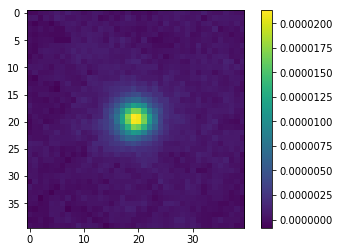

In [6]:
mappath = '/scratch/r/rbond/msyriac/data/depot/tilec/v1.2.0_20200324/map_v1.2.0_joint_boss/'

t = QTable.read('madcows/AdvACT_S18Clusters_v1.0-beta.fits')

boss_mask = enmap.read_map(mappath + "tilec_mask.fits")
boss_map = enmap.read_map(mappath + 'tilec_single_tile_boss_comptony_map_v1.2.0_joint.fits')

ra_temp = t['RADeg']
dec_temp = t['decDeg']
ra, dec = np.array(ra_temp), np.array(dec_temp)

boss_stack = stack(ra, dec, boss_map, boss_mask)
plt.imshow(boss_stack[0])
plt.colorbar()
plt.show()
#plt.savefig("boss_stack_act_y.png")
plt.close()




Number in stack: 337


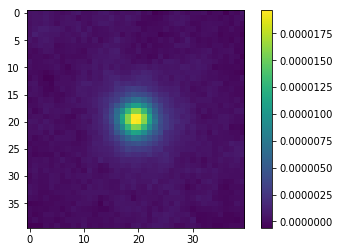

In [7]:
#plots = enplot.plot(enmap.upgrade(boss_stack,5),grid=False, colorbar=True,color='gray')
#enplot.write("boss_stack_act_y",plots)

d56_path = '/scratch/r/rbond/msyriac/data/depot/tilec/v1.2.0_20200324/map_v1.2.0_joint_deep56/'

d56_mask = enmap.read_map(d56_path + "tilec_mask.fits")
d56_map = enmap.read_map(d56_path + 'tilec_single_tile_deep56_comptony_map_v1.2.0_joint.fits')


d56_stack = stack(ra, dec, d56_map, d56_mask)
plt.imshow(d56_stack[0])
plt.colorbar()
plt.show()
#plt.savefig("d56_stack_act_y.png")
plt.close()




Number in stack: 1281


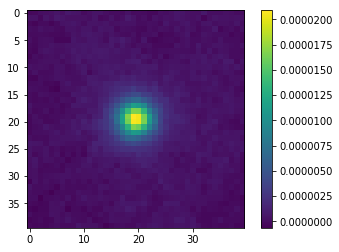

In [8]:
comb_stack = stack(ra, dec, boss_map, boss_mask, d56_map, d56_mask)
plt.imshow(comb_stack[0])
plt.colorbar()
plt.show()
#plt.savefig("comb_stack_act_y.png")
plt.close()

Number above cut: 2839
Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number in stack: 379
1.50832102459e-07
8.68975310657e-08


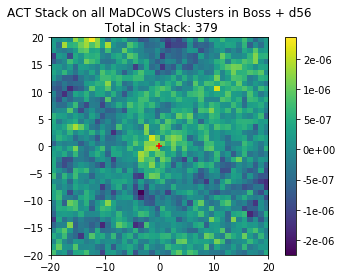

In [9]:
mdcw_ra = mdcw_catalog[1].data['RADeg']
mdcw_dec =mdcw_catalog[1].data['decDeg']
mdcw_ra, mdcw_dec = np.array(mdcw_ra), np.array(mdcw_dec)
mdcw_rich = mdcw_catalog[1].data['Rich']

in_act = ['MOO J0018+0000','MOO J0019+0209','MOO J0028-1005','MOO J0048+1757','MOO J0101+0030','MOO J0102+0201','MOO J0105+1324','MOO J0105-1839','MOO J0120-0304','MOO J0125-0802','MOO J0129-1640','MOO J0132+0329','MOO J0136-0959','MOO J0208-0935','MOO J0234-0107','MOO J0239-1035','MOO J0300+0124','MOO J0303+1857','MOO J0308-2915','MOO J0353+0832','MOO J0448-1705','MOO J0846+1504','MOO J0934+1751','MOO J0936+0337','MOO J1014+0038','MOO J1029+0017','MOO J1048+0743','MOO J1053+1052','MOO J1140+1522','MOO J1142+1346','MOO J1142+1527','MOO J1149+0921','MOO J1204+1525','MOO J1208+0501','MOO J1241+0011','MOO J1254+0948','MOO J1310+1707','MOO J1322-0228','MOO J1346-0142','MOO J1354+1329','MOO J1355+1606','MOO J1414+0227','MOO J1418+0723','MOO J1424-0141','MOO J1454+0628','MOO J1455+0439','MOO J1514+1346','MOO J1521+0452','MOO J1525+1541','MOO J1536+0953','MOO J1620+1340','MOO J2146-0320','MOO J2205-2955','MOO J2231+1130','MOO J2235+1320','MOO J2316+0920','MOO J2319-1856','MOO J2358+1836']

names = mdcw_catalog[1].data['name']

flags = [True]*len(mdcw_ra)

for i, name in enumerate(names):
    #print(name)
    if name in in_act:
        #print(i)
        flags[i] = False

print("Number above cut: {}".format(len(mdcw_ra)))

print("Number before confirmed removal: {}".format(len(mdcw_ra)))
mdcw_ra = mdcw_ra[flags]
mdcw_dec = mdcw_dec[flags]
mdcw_rich = mdcw_rich[flags]
print("Number after confirmed removal: {}".format(len(mdcw_ra)))

mdcw_stack, stack_num = stack(mdcw_ra, mdcw_dec, boss_map, boss_mask, d56_map, d56_mask)

out, cen, cen_d, out_d = 0,0,0,0

for i in range(len(mdcw_stack[0])):
    for j in range(len(mdcw_stack[0])):
        if (28<i<32) & (28<j<32):
            cen += mdcw_stack[i][j]
            cen_d += 1
        else:
            out += mdcw_stack[i][j]
            out_d += 1
print(cen/cen_d)
print(out/out_d)

plot = plt.imshow(mdcw_stack, extent = [-20,20,-20,20])
plt.scatter(0,0, marker = '+', color = 'r')
plt.colorbar(plot, format='%.0e')
plt.title("ACT Stack on all MaDCoWS Clusters in Boss + d56\n Total in Stack: {}".format(stack_num))
plt.savefig("mdcw_stack_act_y.png")
plt.show()
plt.close()

Number above cut: 61
Number in stack: 5
2.00357799145e-06
5.39777686014e-07


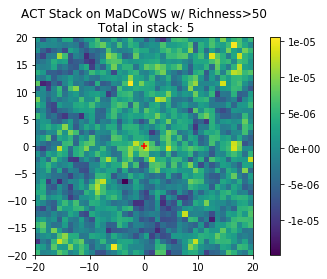

In [ ]:
#print(mdcw_catalog[1].header)


rich_cut = 50
rich_high = 60
mdcw_cut = np.where((rich_cut<np.array(mdcw_rich)) & (np.array(mdcw_rich)<rich_high))[0]


print("Number above cut: {}".format(len(mdcw_cut)))

mdcw_cut_ra = mdcw_ra[mdcw_cut]
mdcw_cut_dec = mdcw_dec[mdcw_cut]

mdcw_stack, stack_num = stack(mdcw_cut_ra, mdcw_cut_dec, boss_map, boss_mask, d56_map, d56_mask)

#print('Average in central 10x10: {}'.format(np.mean(mdcw_stack[25:35][25:35])))
#print(mdcw_stack[0][25:35])
cen, out, cen_d, out_d = 0, 0, 0, 0

for i in range(len(mdcw_stack[0])):
    for j in range(len(mdcw_stack[0])):
        if (28<i<32) & (28<j<32):
            cen += mdcw_stack[i][j]
            cen_d += 1
        else:
            out += mdcw_stack[i][j]
            out_d += 1
print(cen/cen_d)
print(out/out_d)


plot = plt.imshow(mdcw_stack, extent = [-20,20,-20,20])
plt.colorbar(plot, format='%.0e')
plt.scatter(0,0, marker = '+', color = 'r')
plt.title("ACT Stack on MaDCoWS w/ Richness>{}\n Total in stack: {}".format(rich_cut, stack_num))
plt.savefig("mdcw_cut_stack_act_y.png")
plt.show()
plt.close()

In [ ]:
a,b = stacker(mdcw_catalog, 40, 1000, boss_map, boss_mask, d56_map, d56_mask)

Number before confirmed removal: 2839
Number after confirmed removal: 2781
Number above cut: 2781


In [ ]:
for i in range(0, 100, 10):
    a,b = stacker(mdcw_catalog, i, i+10, boss_map, boss_mask, d56_map, d56_mask)
    if a == None:
        print("For  richness bin {} to {}, no items in stack".format(i, i+10))
        continue
    print("For richness bin {} to {} cen/cen_d = {}, out/out_d = {}, s/n = {}".format(i, i+10, a, b, a/b))
